# Implementation of a Random Forest classifier

For clarity of code, it is implemented in a different file. Overal, this follows the same guideline as hands_on_classif2_audio

## TO ADD : R SQUARED METRIC for hyperparams

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

"Machine learning tools"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score
import pickle

from classification.datasets import Dataset
from classification.utils.plots import plot_specgram, show_confusion_matrix, plot_decision_boundaries
from classification.utils.utils import accuracy
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

np.random.seed(0)

In [3]:
fm_dir = "data/feature_matrices/" # where to save the features matrices
model_dir = "data/models/" # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

## Create the dataset and compute the matrix

In [4]:
# Create dataset
dataset = Dataset()
classnames = dataset.list_classes()

# print("\n".join(classnames))

fvds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=770, shift_pct=0.0)

len_fv = len(fvds["birds", 0])                  # number of items in a feature vector
n_fv = len(fvds)                                # number of sounds in the dataset
n_audiofiles = dataset.naudio                   # number of audio files in each class
n_class = dataset.nclass                        # number of classes

train_prop = 0.7                                # proportion of files used for training
n_learn = round(train_prop) * n_audiofiles      # number of sounds used for training

# Data augmentation not yet implemented
data_aug_factor = 1                             # should be an integer
class_ids_aug = np.repeat(classnames, n_audiofiles*data_aug_factor)

# Compute the maxtrixed dataset
X = np.zeros((data_aug_factor*n_class*n_audiofiles, len_fv))
for s in range(data_aug_factor):
    for class_index, classname in enumerate(classnames): # loop over all classes
        for index in range(n_audiofiles): # loop over every audio file of the current class
            fv = fvds[classname, index]
            X[s*n_class*n_audiofiles + class_index*n_audiofiles+index, :] = fv 
y = class_ids_aug.copy()

np.save(fm_dir+"feature_matrix_2D_randomforest.npy", X)
print('Shape of the feature matrix : {}'.format(X.shape))
print('Number of labels : {}'.format(len(y)))

Shape of the feature matrix : (200, 320)
Number of labels : 200


## Create classifier

recall :  [0.57142857 0.52941176 0.75       0.77777778 0.77777778]
precision :  [0.66666667 0.75       0.75       0.58333333 0.53846154]
Accuracy of Random Forest with fixed train/validation sets : 65.6%


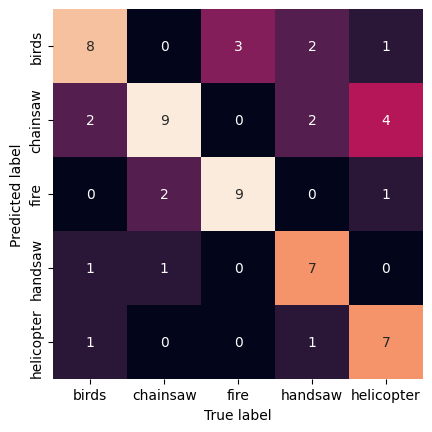

In [5]:
randomForestClassifier = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=20)
# Key parameters are the ones in parenthesis. Some others may be useful to change !

# Fit the model
class_ids_aug = np.repeat(classnames, n_audiofiles*data_aug_factor) 
y = class_ids_aug.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_prop), stratify=y) # is stratify necessary ? 

randomForestClassifier.fit(X_train, y_train)
prediction_rf = randomForestClassifier.predict(X_test)

accuracy_rf = accuracy(prediction_rf, y_test)
precision_rf = precision_score(prediction_rf, y_test, average=None)
recall_rf = recall_score(prediction_rf, y_test, average=None)
print("recall : ", recall_rf)
print("precision : ", precision_rf)

print('Accuracy of Random Forest with fixed train/validation sets : {:.1f}%'.format(100*accuracy_rf))
# print('Precision of Random Forest with fixed train/validation sets : {:.1f}%'.format(100*precision_rf))
# print('Recall of Random Forest with fixed train/validation sets : {:.1f}%'.format(100*recall_rf))
show_confusion_matrix(prediction_rf, y_test, classnames)

### Cross-validation
Dataset neither normalized nor reduced

In [6]:
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)

accuracy_rf = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_train,y_train)):
  (idx_learn, idx_val) = idx
  randomForestClassifier.fit(X_train[idx_learn], y_train[idx_learn])
  prediction_rf = randomForestClassifier.predict(X_train[idx_val])
  accuracy_rf[k] = accuracy(prediction_rf, y_train[idx_val])

print('Mean accuracy of Random Forest with n_splits-Fold CV: {:.1f}%'.format(100*accuracy_rf.mean()))
print('Std deviation in accuracy of KNN with n_splits-Fold CV: {:.1f}%'.format(100*accuracy_rf.std()))

filename = 'randomforest.pickle'
pickle.dump(randomForestClassifier, open(model_dir+filename, 'wb'))

Mean accuracy of Random Forest with n_splits-Fold CV: 60.4%
Std deviation in accuracy of KNN with n_splits-Fold CV: 8.8%


## Normalization

In [ ]:
X_train_normalized = np.zeros_like(X_train)
for i in range(len(X_train)):
  if (np.linalg.norm(X_train[i]) != 0):
    X_train_normalized[i] = X_train[i] / np.linalg.norm(X_train[i])

rf_classifier_normalized = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=20)
rf_classifier_normalized.fit(X_train_normalized, y_train)

X_test_normalized = np.zeros_like(X_test)
for i in range(len(X_test)):
  if (np.linalg.norm(X_train[i]) != 0):
    X_test_normalized[i] = X_test[i] / np.linalg.norm(X_test[i])

prediction_rf_normalized = rf_classifier_normalized.predict(X_test_normalized)
show_confusion_matrix(prediction_rf_normalized, y_test, classnames) # y_test or train???????????
accuracy_rf_normalized = accuracy(prediction_rf_normalized, y_test)
print('Accuracy of normalized Random Forest: {:.1f}%'.format(100*accuracy_rf_normalized))

## Dimension reduction

With a PCA

In [ ]:
n=139 # Number of principal components kept
pca = PCA(n_components=n,whiten=True)

X_train_reduced = pca.fit_transform(X_train_normalized)
X_test_reduced = pca.transform(X_test)

print('Shape of the reduced learning matrix : {}'.format(X_train_reduced.shape))


rf_classifier_reduced = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=20)
rf_classifier_reduced.fit(X_train_reduced, y_train)
prediction_rf_reduced = rf_classifier_reduced.predict(X_test_reduced)
show_confusion_matrix(prediction_rf_reduced, y_test, classnames)
accuracy_rf_reduced = accuracy(prediction_rf_reduced, y_test)
print('Accuracy of normalized Random Forest with PCA (dimension reduction): {:.1f}%'.format(100*accuracy_rf_normalized))

## Analysis of hyperparameters

Here, we test the impact of some of the hyperparameters of the model on the classifier.

Apparently, hyperparameters don't impact so much the classifier, but it is still interesting to optimize the parameters.

Parameters analyzed are : n_estimator (number of trees in the forest), min_sample_leaf (minimum number of samples required to be at a leaf internal node, if too small we will capture too much noise), max_depth (maximum depth of a tree).

When one parameter is tested, other are set to default values provided in the function.

Let us keep in mind that we don't analyze the performance of the model in terms of speed, and that might be a problem for real time applications!

In the first time, analysis is done without normalization and PCA.

In [ ]:
# Simulation takes some time, hence leave those values to false if not needed.
test_n_estimator = False
test_min_sample_leaf = False
test_max_depth = False

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)



if test_n_estimator == True:
    n_estimator = np.arange(1, 500, 25)
    accuracies = np.zeros((len(n_estimator), n_splits))
    print(n_estimator)
    
    for i in range(len(n_estimator)):
        classifier = RandomForestClassifier(n_estimators=n_estimator[i])
        for k, index in enumerate(kf.split(X_train,y_train)):
                (idx_learn, idx_val) = index
                classifier.fit(X_train[idx_learn], y_train[idx_learn])
                prediction = classifier.predict(X_train[idx_val])
                accuracies[i,k] = accuracy(prediction, y_train[idx_val])
    means = accuracies.mean(axis=1) 
    stds = accuracies.std(axis=1) 

    "Plot"
    plt.figure(figsize=(6,3))
    plt.plot(n_estimator, means, '.-b', label='RF')
    plt.fill_between(n_estimator,means-stds,means+stds,alpha=0.2,color='b')
    plt.ylim(0,1)
    plt.xlabel('n_estimator')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


if test_min_sample_leaf == True:
    min_sample_leaf = np.arange(1, 100, 5)
    accuracies = np.zeros((len(min_sample_leaf), n_splits))
    print(min_sample_leaf)

    for i in range(len(min_sample_leaf)):
        classifier = RandomForestClassifier(min_samples_leaf=min_sample_leaf[i])
        for k, index in enumerate(kf.split(X_train,y_train)):
                (idx_learn, idx_val) = index
                classifier.fit(X_train[idx_learn], y_train[idx_learn])
                prediction = classifier.predict(X_train[idx_val])
                accuracies[i,k] = accuracy(prediction, y_train[idx_val])
    means = accuracies.mean(axis=1) 
    stds = accuracies.std(axis=1) 

    "Plot"
    plt.figure(figsize=(6,3))
    plt.plot(min_sample_leaf, means, '.-b', label='RF')
    plt.fill_between(min_sample_leaf,means-stds,means+stds,alpha=0.2,color='b')
    plt.ylim(0,1)
    plt.xlabel('min_sample_leaf')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


if test_max_depth == True:
    max_depths = np.arange(1, 500, 50)
    accuracies = np.zeros((len(max_depths), n_splits))
    print(max_depths)

    for i in range(len(max_depths)):
        classifier = RandomForestClassifier(max_depth=max_depths[i])
        for k, index in enumerate(kf.split(X_train,y_train)):
                (idx_learn, idx_val) = index
                classifier.fit(X_train[idx_learn], y_train[idx_learn])
                prediction = classifier.predict(X_train[idx_val])
                accuracies[i,k] = accuracy(prediction, y_train[idx_val])
    means = accuracies.mean(axis=1) 
    stds = accuracies.std(axis=1) 

    "Plot"
    plt.figure(figsize=(6,3))
    plt.plot(max_depths, means, '.-b', label='RF')
    plt.fill_between(max_depths,means-stds,means+stds,alpha=0.2,color='b')
    plt.ylim(0,1)
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## Data augmentation

In [ ]:
AudioUtilInst = AudioUtil()

fvds.mod_data_aug(['add_noise'])
data_aug_factor = 2
y_aug = np.repeat(classnames, dataset.naudio*fvds.data_aug_factor) # Labels


X_aug = np.zeros((fvds.data_aug_factor*n_class*n_audiofiles, len_fv))
for s in range(fvds.data_aug_factor):
    for index in range(dataset.naudio):
        for class_index, classname in enumerate(classnames):
            fv = fvds[classname, index]
            X_aug[s*n_class*n_audiofiles + class_index*n_audiofiles + index, :] = fv

# np.save(fm_dir+"feature_matrix_2D_aug_RF")

# Manually modify the 200 last elems to add noise. This is a very bad implementation, it should change
for i in range(200, 400):
    fv = X_aug[i].copy()
    fv_noise, sr = AudioUtilInst.add_noise((fv,1)) # Arbitrary sample rate, we don't care about it
    X_aug[i] = fv_noise

# Instantiate a new classifier
randomForestClassifier = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=20)

# Fit the model
class_ids_aug = np.repeat(classnames, n_audiofiles*data_aug_factor) 
y = class_ids_aug.copy()

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=(1-train_prop), stratify=y) # is stratify necessary ? 

randomForestClassifier.fit(X_train, y_train)
prediction_rf = randomForestClassifier.predict(X_test)

accuracy_rf = accuracy(prediction_rf, y_test)
precision_rf = precision_score(y_test, prediction_rf, average=None)
recall_rf = recall_score(y_test, prediction_rf, average=None)
print("recall : ", recall_rf)
print("precision : ", precision_rf)

print('Accuracy of Random Forest with fixed train/validation sets : {:.1f}%'.format(100*accuracy_rf))
show_confusion_matrix(prediction_rf, y_test, classnames)



## Cross-Validation with augmented dataset

In [ ]:
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)

accuracy_rf = np.zeros((n_splits,))
precision_rf = np.zeros((5,))
recall_rf = np.zeros((5,))

for k, idx in enumerate(kf.split(X_train,y_train)):
  (idx_learn, idx_val) = idx
  randomForestClassifier.fit(X_train[idx_learn], y_train[idx_learn])
  prediction_rf = randomForestClassifier.predict(X_train[idx_val])
  accuracy_rf[k] = accuracy(prediction_rf, y_train[idx_val])
  precision_rf += precision_score(y_train[idx_val], prediction_rf, average=None)
  recall_rf += recall_score(y_train[idx_val], prediction_rf, average=None)

recall_rf /= n_splits
precision_rf /= n_splits

print("Mean recall : ", recall_rf)
print("Mean precision : ", precision_rf)

print('Mean accuracy of Random Forest with n_splits-Fold CV: {:.1f}%'.format(100*accuracy_rf.mean()))
print('Std deviation in accuracy of KNN with n_splits-Fold CV: {:.1f}%'.format(100*accuracy_rf.std()))

## Hyperparameters analysis


In [ ]:
%matplotlib tk
# Simulation takes some time, hence leave those values to false if not needed.
test_n_estimator = True
test_min_sample_leaf = False
test_max_depth = False

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)



if test_n_estimator == True:
    n_estimator = np.arange(1, 150, 3)
    accuracies = np.zeros((len(n_estimator), n_splits))
    print(n_estimator)
    
    for i in range(len(n_estimator)):
        classifier = RandomForestClassifier(n_estimators=n_estimator[i])
        for k, index in enumerate(kf.split(X_train,y_train)):
                (idx_learn, idx_val) = index
                classifier.fit(X_train[idx_learn], y_train[idx_learn])
                prediction = classifier.predict(X_train[idx_val])
                accuracies[i,k] = accuracy(prediction, y_train[idx_val])
    means = accuracies.mean(axis=1) 
    stds = accuracies.std(axis=1) 

    "Plot"
    plt.figure(figsize=(6,3))
    plt.plot(n_estimator, means, '.-b', label='RF')
    plt.fill_between(n_estimator,means-stds,means+stds,alpha=0.2,color='b')
    plt.ylim(0,1)
    plt.xlabel('n_estimator')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


if test_min_sample_leaf == True:
    min_sample_leaf = np.arange(1, 100, 5)
    accuracies = np.zeros((len(min_sample_leaf), n_splits))
    print(min_sample_leaf)

    for i in range(len(min_sample_leaf)):
        classifier = RandomForestClassifier(min_samples_leaf=min_sample_leaf[i])
        for k, index in enumerate(kf.split(X_train,y_train)):
                (idx_learn, idx_val) = index
                classifier.fit(X_train[idx_learn], y_train[idx_learn])
                prediction = classifier.predict(X_train[idx_val])
                accuracies[i,k] = accuracy(prediction, y_train[idx_val])
    means = accuracies.mean(axis=1) 
    stds = accuracies.std(axis=1) 

    "Plot"
    plt.figure(figsize=(6,3))
    plt.plot(min_sample_leaf, means, '.-b', label='RF')
    plt.fill_between(min_sample_leaf,means-stds,means+stds,alpha=0.2,color='b')
    plt.ylim(0,1)
    plt.xlabel('min_sample_leaf')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


if test_max_depth == True:
    max_depths = np.arange(1, 500, 50)
    accuracies = np.zeros((len(max_depths), n_splits))
    print(max_depths)

    for i in range(len(max_depths)):
        classifier = RandomForestClassifier(max_depth=max_depths[i])
        for k, index in enumerate(kf.split(X_train,y_train)):
                (idx_learn, idx_val) = index
                classifier.fit(X_train[idx_learn], y_train[idx_learn])
                prediction = classifier.predict(X_train[idx_val])
                accuracies[i,k] = accuracy(prediction, y_train[idx_val])
    means = accuracies.mean(axis=1) 
    stds = accuracies.std(axis=1) 

    "Plot"
    plt.figure(figsize=(6,3))
    plt.plot(max_depths, means, '.-b', label='RF')
    plt.fill_between(max_depths,means-stds,means+stds,alpha=0.2,color='b')
    plt.ylim(0,1)
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
